In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

ROOT_DATA_DIR = os.path.join('..', 'Data', 'PCB_DATASET')
TEMPLATE_DIR = os.path.join(ROOT_DATA_DIR, 'PCB_USED')
TEST_IMAGES_DIR = os.path.join(ROOT_DATA_DIR, 'images', 'Short')

TEMPLATE_NAME = '01.JPG'
TEST_NAME = '01_short_02.JPG'

print(f"Loading Template: {os.path.join(TEMPLATE_DIR, TEMPLATE_NAME)}")
print(f"Loading Test Image: {os.path.join(TEST_IMAGES_DIR, TEST_NAME)}")

Loading Template: ..\Data\PCB_DATASET\PCB_USED\01.JPG
Loading Test Image: ..\Data\PCB_DATASET\images\Short\01_short_02.JPG


Images loaded successfully.


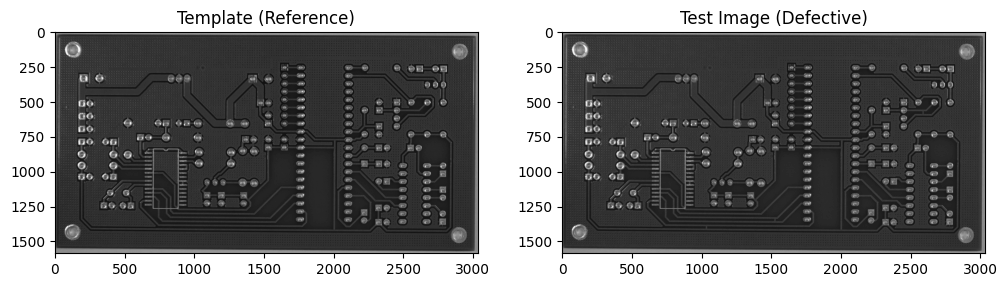

In [ ]:

template = cv2.imread(os.path.join(TEMPLATE_DIR, TEMPLATE_NAME), 0)
test_img = cv2.imread(os.path.join(TEST_IMAGES_DIR, TEST_NAME), 0)

if template is None or test_img is None:
    raise FileNotFoundError("Error: Could not load images. Check paths and file extensions (.JPG/.jpg).")

print("Images loaded successfully.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title("Template (Reference)")

plt.subplot(1, 2, 2)
plt.imshow(test_img, cmap='gray')
plt.title("Test Image (Defective)")

plt.show()

In [3]:

orb = cv2.ORB_create(nfeatures=5000)
kp1, des1 = orb.detectAndCompute(template, None)
kp2, des2 = orb.detectAndCompute(test_img, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
good_matches = matches[:50] 

points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

height, width = template.shape
aligned_test_img = cv2.warpPerspective(test_img, H, (width, height))

print("Image alignment complete.")

Image alignment complete.


In [4]:

difference_map = cv2.absdiff(template, aligned_test_img)

ret, defect_mask_raw = cv2.threshold(difference_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
defect_mask = cv2.erode(defect_mask_raw, kernel, iterations=1)
defect_mask = cv2.dilate(defect_mask, kernel, iterations=1)

print(f"Otsu Threshold value: {ret:.2f}")
print("Defect mask generated.")

Otsu Threshold value: 1.00
Defect mask generated.


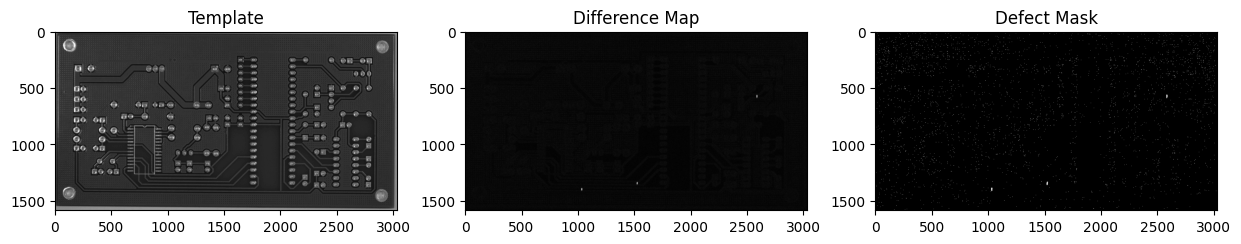

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(template, cmap='gray')
plt.title("Template")

plt.subplot(1, 3, 2)
plt.imshow(difference_map, cmap='gray')
plt.title("Difference Map")

plt.subplot(1, 3, 3)
plt.imshow(defect_mask, cmap='gray')
plt.title("Defect Mask")

plt.show()